In [1]:
# import torch
# from PIL import Image
# from torchvision import transforms
# model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=True)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet34', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet152', pretrained=True)
# model.eval()

In [22]:
import torchvision.models as models
model = models.vgg16(pretrained=True)
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [23]:
import _init_paths
import numpy as np
import torch
from PIL import Image
from torchvision import transforms


In [3]:
# # Helper for hook some specific layer.
# activation = {}

# def get_activation(name):
#     def hook(model, input, output):
#         activation[name] = output.detach()
#     return hook

In [24]:
def vgg_intermediate(vgg, x):
    """ Get intermediate results of specifc model.
        Note: This is NOT a generalized function for all torch models,
              due to the different arch. of models.
    """
    
    # forward the features layers of VGG.
    for l in list(model.features.modules())[0]:
        x = l(x)

    # avgpool of VGG.
    x = list(model.avgpool.modules())[0](x)
    
    # flatten for FC layers.
    x = x.view(x.shape[0], -1)
    
    # go through FC layers.
    for l in list(model.classifier.modules())[0]:
        x = l(x)

    return x

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt      # plot library.
from IPython.display import display 
%matplotlib inline

# TARGET_LAYER = 'fc'
TARGET_LAYER = 'avgpool'

# TARGET_LAYER = 'classifier'

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

if torch.cuda.is_available():
    model.to('cuda')

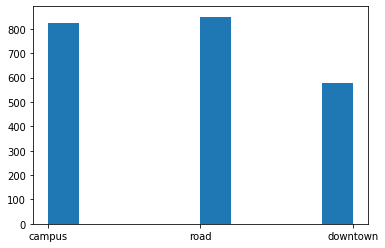

In [26]:
def scene_tag(file_name):
    set_tag = file_name.split('_')[0][-2:]
    if set_tag == "06" or set_tag == "09":
        return 'campus'
    if set_tag == "07" or set_tag == "10":
        return 'road'
    if set_tag == "08" or set_tag == "11":
        return 'downtown'

# Dealing with the filename first.
BASE_DIR = '/home/superorange5/data/kaist_test/kaist_test_visible'
file_names = [f for f in os.listdir(BASE_DIR) if '.png' in f]
scene_tags = [scene_tag(f) for f in file_names]

plt.hist(scene_tags);

In [27]:
%%time 
imgs = [Image.open(os.path.join(BASE_DIR, fn)) for fn in file_names]
imgs = [preprocess(img).unsqueeze(0) for img in imgs]

CPU times: user 3min 36s, sys: 712 ms, total: 3min 36s
Wall time: 34.4 s


In [31]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [29]:
%%time
outputs = []
batch_sz = 32
n_batch = len(imgs)//batch_sz
res_batch = len(imgs)%batch_sz

# if TARGET_LAYER == 'avgpool':
#     model.avgpool.register_forward_hook(get_activation('avgpool'))
    
# if TARGET_LAYER == 'fc':
#     model.fc.register_forward_hook(get_activation(TARGET_LAYER))
    

with torch.no_grad():

    for i in range(n_batch):
        in_batch = torch.cat(imgs[i*batch_sz:(i+1)*batch_sz]).to('cuda')

        x = vgg_intermediate(model, in_batch)
        outputs.append(x)

    # last incomplete batch.
    in_batch = torch.cat(imgs[-res_batch:]).to('cuda')
    x = vgg_intermediate(model, in_batch)
    outputs.append(x)

outputs = torch.cat(outputs)
X = outputs.to('cpu')
    
print("Output shape: {:}".format(outputs.shape))

AttributeError: 'VGG' object has no attribute 'avgpool'

In [9]:
# X = X.flatten(start_dim=1)
# print(X_out.shape)

In [10]:
# Save the latent vector.

# np.save("latent_{:}-out.npy".format(outputs.shape[1]), X)

In [11]:
# TSNE?

In [12]:
%%time
from sklearn.manifold import TSNE
# from sklearn.decomposition import PCA

X_embedded = TSNE(n_components=2).fit_transform(X)

# X_embedded = TSNE(n_components=2, perplexity=30.0,
#                 early_exaggeration=30.0,
#                 learning_rate=200.0,
#                 n_iter=1000,
#                 n_iter_without_progress=500,).fit_transform(X)

CPU times: user 3min 16s, sys: 251 ms, total: 3min 16s
Wall time: 1min 42s


In [11]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 12));

for idx, tag in enumerate(['campus', 'road', 'downtown']):
    mask = np.asarray(scene_tags) == tag
    plt.scatter(X_embedded[mask, 0], X_embedded[mask, 1], label=tag, alpha=0.7)
    
plt.legend(fontsize=14);

NameError: name 'scene_tags' is not defined

<Figure size 864x864 with 0 Axes>

In [12]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

def optimalK(data, nrefs=5, maxClusters=15):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):
#     for gap_index, k in enumerate(range(10, 50, 5)):

        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)

        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_

        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)

    return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal

In [13]:
%%time
k, gapdf = optimalK(X_embedded, nrefs=5, maxClusters=20)

NameError: name 'X_embedded' is not defined

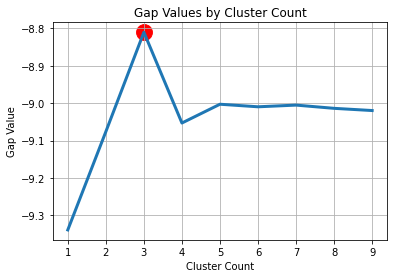

In [39]:
plt.plot(gapdf.clusterCount, gapdf.gap, linewidth=3)
plt.scatter(gapdf[gapdf.clusterCount == k].clusterCount, gapdf[gapdf.clusterCount == k].gap, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

In [40]:
%%time
# from sklearn.decomposition import PCA.
X_embedded_3d = TSNE(n_components=3).fit_transform(X)

CPU times: user 1min 17s, sys: 248 ms, total: 1min 18s
Wall time: 19.6 s


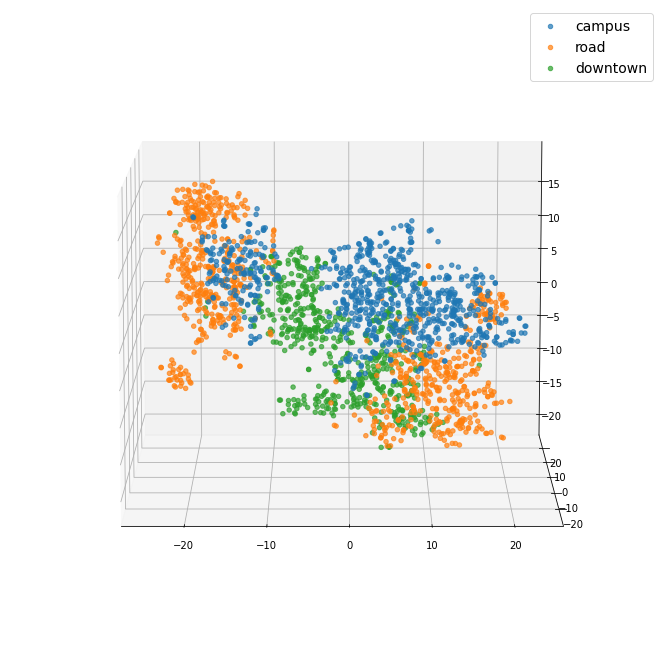

In [41]:
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')

# X_embedded_3d = TSNE(n_components=3).fit_transform(X[:,:,0,0])

angle = -90
ax.view_init(10, angle)

for idx, tag in enumerate(['campus', 'road', 'downtown']):
    mask = np.asarray(scene_tags) == tag
    
    ax.scatter3D(X_embedded_3d[mask, 0], X_embedded_3d[mask, 1], X_embedded_3d[mask, 2], label=tag, alpha=0.7)
    
plt.legend(fontsize=14);

In [ ]:
# from sklearn.decomposition import PCA

# pca_3d = PCA(n_components=3).fit_transform(X[])

In [ ]:
# fig = plt.figure(figsize=(12, 12))
# ax = plt.axes(projection='3d')

# for idx, tag in enumerate(['campus', 'road', 'downtown']):
#     mask = np.asarray(scene_tags) == tag
    
#     ax.scatter3D(pca_3d[mask, 0], pca_3d[mask, 1], pca_3d[mask, 2], label=tag, alpha=0.7)
    
# plt.legend(fontsize=14);